In [ ]:
# Run this cell to install this project and its dependencies, e.g., on Google Colab

try:
    import sampling_paths  # noqa: F401
except ImportError:
    import sys  # noqa: F401

    !{sys.executable} -m pip install --group notebooks git+https://github.com/jeertmans/sampling-paths.git

(sampling-paths)=
# Sampling Path Candidates with Machine Learning

This notebook aims at being a tutorial to reproduce the results presented in the paper
*Transform-Invariant Generative Ray Path Sampling for Efficient Radio Propagation Modeling with Point-to-Point Ray Tracing*,
and assumes you are familiar with its content.

:::{important}
This notebook presents **version 2** of our work on the topic of *sampling path candidates*. You can access **v1**, as presented at the 2025 IEEE International Conference on Machine Learning for Communication and Networking (ICMLCN) in our paper *Towards Generative Ray Path Sampling for Faster Point-to-Point Ray Tracing* {cite}`sampling-icmlcn2025` [by clicking here](https://differt.rtfd.io/icmlcn2025/notebooks/sampling_paths.html).
:::

**You can run it locally or with Google Colab** by clicking on the rocket
at the top of this page!

:::{tip}
On Google Colab, make sure to select a GPU or TPU runtime for a faster experience.
:::

If you find this tutorial useful and plan on using this tool for your publications,
please cite our work, see {ref}`citing`.

:::{warning}
Training the models can take quite some time.

If you want to bypass the training and use a pre-trained model,
you can download the weights from the
[releases page](https://github.com/jeertmans/DiffeRT/releases/tag/icmlcn2025) and
load then with `Model.load_weights`.
:::

## Summary

In our work, we present a Machine Learning model that aims at reducing the computational complexity
of exhaustive point-to-point Ray Tracing by learning how to sample path candidates.
For further details, please refer to the paper.

## Setup

Below are the important steps to properly setup the environment.

### Imports

Unlike for the previous version of our work, we have refactored the codebase to be more modular and reusable.
This means that most of the code is located in separate files,
available on [GitHub](https://github.com/jeertmans/sampling-paths),
and installed as a Python package (`sampling_paths`).

This notebook is meant to be a tutorial on how to use the package to train and use the model, and thus does not contain the implementation details of the model itself.

We need to import quite a few Python modules,
but all of them should be installed with
`pip install --group notebooks git+https://github.com/jeertmans/sampling-paths.git`
(assuming `pip >= 25.1`).
The following cell is hidden by default for readability.

In [ ]:
from collections import defaultdict

import equinox as eqx
import jax
import jax.numpy as jnp
import jax.random as jr
import matplotlib.pyplot as plt
import optax
import plotly.graph_objects as go
import treescope
from tqdm.notebook import tqdm, trange

from differt.plotting import reuse, set_defaults
from differt.scene import (
    download_sionna_scenes,
)
from sampling_paths.utils import (
    BASE_SCENE,
    random_scene,
    validation_scene_keys,
    train_dataloader,
)

from sampling_paths.agent import Agent
from sampling_paths.model import Model

### Pretty Printing

Nested structures, like Machine Learning modules, or more generaly PyTrees, do not render very nicely by default.
To provide the user with an interactive pretty-printing experience, we use `treescope`:

In [ ]:
treescope.basic_interactive_setup(autovisualize_arrays=False)

### JAX Device

While this notebook will run fine all supported JAX devices (i.e., CPU, GPU, and TPU), using a GPU (or a TPU) will usually decrease the computational time by a significant factor.

To check the current active JAX device, use {func}`jax.devices`:

In [ ]:
jax.devices()

[CudaDevice(id=0)]

## Generating the training data

For this tutorial, we restrict ourselves to a simple urban scenario, obtained from Sionna {cite}`sionna`,
from which we will derive random scenes.

The `BASE_SCENE` object is the `'simple_stree_canyon'` scenario from Sionna, which will be used to generate random scenes for training and evaluation.

In [ ]:
download_sionna_scenes()  # Let's download Sionna scenes (from the main branch)

In [ ]:
set_defaults(
    "plotly"
)  # Our scene is simple, and Plotly is the best backend for online interactive plots :-)

fig = BASE_SCENE.plot()
fig.update_scenes(xaxis_visible=False, yaxis_visible=False,zaxis_visible=False )
fig.update_layout(scene_camera_eye=dict(x=0.2, y=1.2, z=2))
fig.update_layout(paper_bgcolor="rgba(0,0,0,0)", plot_bgcolor="rgba(0,0,0,0)")
import plotly
plotly.io.write_image(fig, "scene.png", format="png", scale=6)
fig

From the `BASE_SCENE` object, we can generate random variations of it.
Two main types of variations are considered here:

1. the number of objects (either triangles or quadrilaterals);
2. and the TX / RX positions.

:::{note}
Unlike with NumPy and other common array libraries,
JAX requires an explicit random key ({func}`jr.key`) whenever you need to generate
pseudo-random numbers. While this can lead to more verbose code, this has the
**major advantage** of making random number generation easily reproducible,
even across multiple devices. *You want the same results? Then just pass the same key!*
:::

Below, we demonstrate how to generate (and plot) a random scene.

In [ ]:
key_example = jr.key(1234)
scene = random_scene(key=key_example)
bounds = BASE_SCENE.mesh.object_bounds
s,e=bounds[3]
scene = eqx.tree_at(lambda s: s.mesh.mask, scene,scene.mesh.mask.at[s:e].set(False))
fig = scene.plot(showlegend=False,tx_kwargs=dict(labels=["TX"]),rx_kwargs=dict(labels=["RX"]))
fig.update_scenes(xaxis_visible=False, yaxis_visible=False,zaxis_visible=False )
fig.update_layout(scene_camera_eye=dict(x=.2, y=-1.2, z=2))
fig.update_layout(paper_bgcolor="rgba(0,0,0,0)", plot_bgcolor="rgba(0,0,0,0)")
import plotly
plotly.io.write_image(fig, "random_scene.png", format="png", scale=6)
fig

In the paper, we study other types of variations, and they can be specified with optional parameters of the `random_scene` function.

In [ ]:
help(random_scene)

Processing path candidates:   0%|          | 0/1 [00:00<?, ?it/s]

(order = 0) Found  0 valid paths our of    1 path candidates.


Processing path candidates:   0%|          | 0/1 [00:00<?, ?it/s]

(order = 1) Found  0 valid paths our of   62 path candidates.


Processing path candidates:   0%|          | 0/1 [00:00<?, ?it/s]

(order = 2) Found  0 valid paths our of 3782 path candidates.


Processing path candidates:   0%|          | 0/1 [00:00<?, ?it/s]

(order = 3) Found  0 valid paths our of 230702 path candidates.


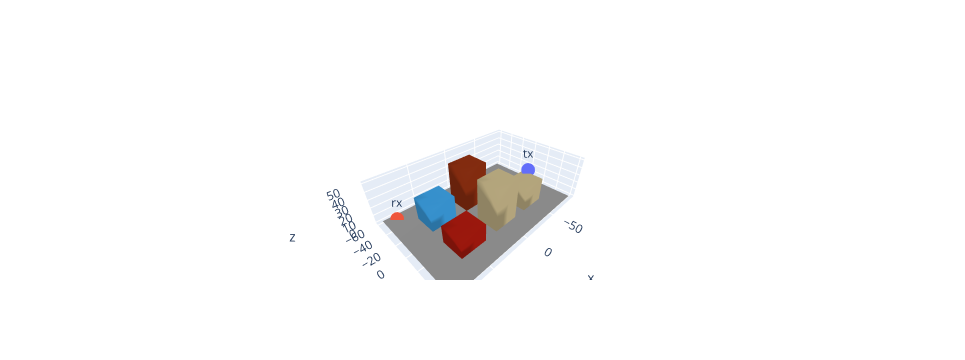

In [ ]:
key_example = jr.key(1234)

with reuse() as fig:
    scene = random_scene(key=key_example)
    scene.plot(showlegend=False)

    num_active_primitives = scene.mesh.num_active_primitives

    for order in [0, 1, 2, 3]:
        num_valid_paths = 0
        if order == 0:
            num_path_candidates = 1
        else:
            num_path_candidates = num_active_primitives * (
                num_active_primitives - 1
            ) ** (order - 1)
        for paths in tqdm(
            scene.compute_paths(order=order, chunk_size=1_000_000),
            desc="Processing path candidates",
            leave=False,
        ):
            num_valid_paths += paths.num_valid_paths
        paths.plot(showlegend=False)
        print(
            f"(order = {order}) Found {num_valid_paths:2d} valid paths our of {num_path_candidates:4d} path candidates."
        )

fig

We then collect some statistics about the scenes we are training on.

In [ ]:
key_stats = jr.key(1234)

for with_ground in [True,False]:
    for in_canyon in [True,False]:
        scenes = train_dataloader(key=key_stats,sample_in_canyon=in_canyon,include_floor=with_ground)
        
        num_valid_paths = defaultdict(list)  # Number of valid paths
        num_total_paths = defaultdict(list)  # Total number of path (candidates)
        
        colors = {0: "black", 1: "blue", 2: "red", 3: "green"}
        
        for _ in trange(
            10_000, desc="Collecting statistics over many realisations", leave=False
        ):
            scene = next(scenes)
            num_active_primitives = scene.mesh.num_active_primitives
            for order in colors:
                num_valid_paths[order].append(0)
                if order == 0:
                    num_path_candidates = 1
                else:
                    num_path_candidates = num_active_primitives * (
                        num_active_primitives - 1
                    ) ** (order - 1)
                num_total_paths[order].append(num_path_candidates)
                for paths in scene.compute_paths(order=order, chunk_size=100_000):
                    num_valid_paths[order][-1] += paths.mask.sum()

        print(f"Statistics for: {with_ground=}, {in_canyon=}")
        for order in colors:
            print(f"\tStatistics for {order = }:")
            num_valid = jnp.array(num_valid_paths[order])
            num_total = jnp.array(num_total_paths[order])
            where = num_total != 0  # We discard rare cases without any candidate
            avg_total = int(num_total.mean(where=where))
            frac = float((num_valid / num_total).mean(where=where))
            frac_one = float((num_valid > 0).sum(where=where) / where.sum())
            print(
                f"\t- an average of {avg_total} path candidates exist;\n"
                f"\t- out of which {frac:.8%} of the paths are valid\n"
                f"\t- and {frac_one:.8%}% of the scenes contained at least one valid path."
            )

Statistics for: with_ground=True, in_canyon=True
	Statistics for order = 0:
	- an average of 1 path candidates exist;
	- out of which 100.00000000% of the paths are valid
	- and 100.00000000%% of the scenes contained at least one valid path.
	Statistics for order = 1:
	- an average of 56 path candidates exist;
	- out of which 4.78715561% of the paths are valid
	- and 100.00000000%% of the scenes contained at least one valid path.
	Statistics for order = 2:
	- an average of 3333 path candidates exist;
	- out of which 0.08695993% of the paths are valid
	- and 91.65899754%% of the scenes contained at least one valid path.
	Statistics for order = 3:
	- an average of 208750 path candidates exist;
	- out of which 0.00121081% of the paths are valid
	- and 58.22199583%% of the scenes contained at least one valid path.


Statistics for: with_ground=True, in_canyon=False
	Statistics for order = 0:
	- an average of 1 path candidates exist;
	- out of which 33.61399770% of the paths are valid
	- and 33.61399770%% of the scenes contained at least one valid path.
	Statistics for order = 1:
	- an average of 56 path candidates exist;
	- out of which 1.43338665% of the paths are valid
	- and 37.26399839%% of the scenes contained at least one valid path.
	Statistics for order = 2:
	- an average of 3333 path candidates exist;
	- out of which 0.01942402% of the paths are valid
	- and 24.65499938%% of the scenes contained at least one valid path.
	Statistics for order = 3:
	- an average of 208750 path candidates exist;
	- out of which 0.00032671% of the paths are valid
	- and 11.64199933%% of the scenes contained at least one valid path.


Statistics for: with_ground=False, in_canyon=True
	Statistics for order = 0:
	- an average of 1 path candidates exist;
	- out of which 100.00000000% of the paths are valid
	- and 100.00000000%% of the scenes contained at least one valid path.
	Statistics for order = 1:
	- an average of 55 path candidates exist;
	- out of which 4.19921316% of the paths are valid
	- and 96.98195457%% of the scenes contained at least one valid path.
	Statistics for order = 2:
	- an average of 3287 path candidates exist;
	- out of which 0.07210675% of the paths are valid
	- and 81.19901419%% of the scenes contained at least one valid path.
	Statistics for order = 3:
	- an average of 205064 path candidates exist;
	- out of which 0.00107784% of the paths are valid
	- and 58.28086734%% of the scenes contained at least one valid path.


Statistics for: with_ground=False, in_canyon=False
	Statistics for order = 0:
	- an average of 1 path candidates exist;
	- out of which 33.61399770% of the paths are valid
	- and 33.61399770%% of the scenes contained at least one valid path.
	Statistics for order = 1:
	- an average of 55 path candidates exist;
	- out of which 1.14101833% of the paths are valid
	- and 32.36168623%% of the scenes contained at least one valid path.
	Statistics for order = 2:
	- an average of 3287 path candidates exist;
	- out of which 0.01524194% of the paths are valid
	- and 20.26046365%% of the scenes contained at least one valid path.
	Statistics for order = 3:
	- an average of 205064 path candidates exist;
	- out of which 0.00029805% of the paths are valid
	- and 10.20630896%% of the scenes contained at least one valid path.


	Statistics for order = 0:
	- an average of 1 path candidates exist;
	- out of which 33.61399770% of the paths are valid
	- and 33.61399770%% of the scenes contained at least one valid path.
	Statistics for order = 1:
	- an average of 55 path candidates exist;
	- out of which 1.14101833% of the paths are valid
	- and 32.36168623%% of the scenes contained at least one valid path.
	Statistics for order = 2:
	- an average of 3287 path candidates exist;
	- out of which 0.01524194% of the paths are valid
	- and 20.26046365%% of the scenes contained at least one valid path.
	Statistics for order = 3:
	- an average of 205064 path candidates exist;
	- out of which 0.00029805% of the paths are valid
	- and 10.20630896%% of the scenes contained at least one valid path.


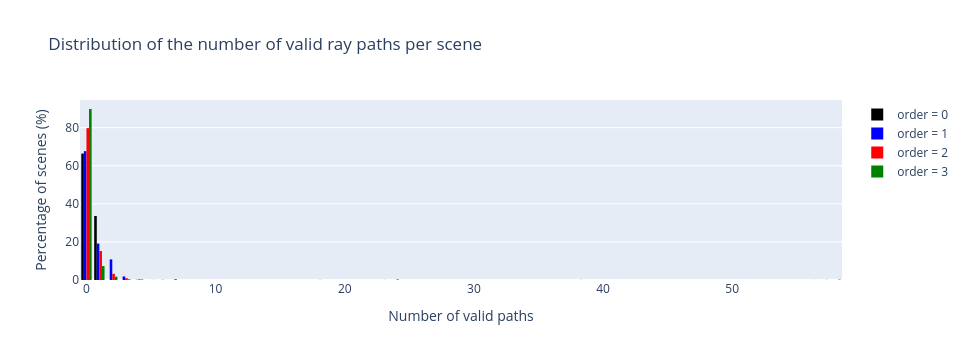

In [ ]:
fig = go.Figure()
for order in colors:
    print(f"\tStatistics for {order = }:")
    num_valid = jnp.array(num_valid_paths[order])
    num_total = jnp.array(num_total_paths[order])
    where = num_total != 0  # We discard rare cases without any candidate
    avg_total = int(num_total.mean(where=where))
    frac = float((num_valid / num_total).mean(where=where))
    frac_one = float((num_valid > 0).sum(where=where) / where.sum())
    print(
        f"\t- an average of {avg_total} path candidates exist;\n"
        f"\t- out of which {frac:.8%} of the paths are valid\n"
        f"\t- and {frac_one:.8%}% of the scenes contained at least one valid path."
    )
    fig.add_histogram(
        x=num_valid,
        histnorm="percent",
        name=f"{order = }",
        marker_color=colors[order],
    )

fig.update_layout(
    title="Distribution of the number of valid ray paths per scene",
    xaxis_title="Number of valid paths",
    yaxis_title="Percentage of scenes (%)",
)

## Reward function

Below, we define a reward function that simply checks
if a generated path candidate would produce a valid ray path.

The {attr}`Paths.mask<differt.geometry.Paths.mask>` attribute
is a boolean array where each entry indicates if the corresponding ray
path is valid or not. As we only have one pair of TX and RX, the sum
of all entries in this mask, when converted to floating point values,
is either 1 or 0.

### Differentiable reward

As {mod}`differt` is a differentiable library, thanks to JAX,
the reward function will be differentiable with respect to its arguments.

### Simulating non-differentiable reward

To observe what a non-differentiable reward would do, you can wrap the
return value of the reward function with
{func}`jax.lax.stop_gradient`, to effectively make the reward static.

We observed that a non-differentiable reward decreases the training performance,
leading to a lower accuracy and hit rate (see later) after the same number of steps.

## Machine Learning model

Our model is made of two parts: an inner flow model, that returns the flows between a parent state and its child states,
and an outer model, that extracts features from the scene, and repeatedly calls the Flow model to generate a path candidate.

:::{note}
While the model below accepts arbitrarily many TXs or RXs,
it only makes sense to train it on a single TX and a single RX at a time,
as different positions usually lead to different path candidates being valid.
:::

### From triangle vertices to feature vectors

This model maps the scene objects into feature vectors, while making sure that:

1. any permutation in the objects ordering results in the same exact permutation of the output vectors;
2. and the output is invariant with respect to any translation, scaling, or rotation operation applied on the scene.

### From features to flows

The second part of our model maps, for each input object,
three feature vectors into a vector of flows:

1. the feature vector of the scene;
2. the feature vector of the object;
3. and the current state vectors, constructed from the feature vector of objects that were selected in previous states.

## Learning

In the trajectory balance equation, $Z$ represents the sum of 

In [ ]:
order = 3
num_embeddings = 126
batch_size = 64
depth = 2

key = jr.key(1234)
model_key, key_training = jr.split(key, 2)

agent = Agent(
    model=Model(order=order,
    num_embeddings=num_embeddings,
          width_size=2*num_embeddings,
    depth=depth,
    dropout_rate=0.1,
                epsilon=0.5,
key=model_key,
         ),
    batch_size=batch_size,
    min_epsilon=0.1,
    optim=optax.adam(3e-6),
)

# Learning the number of valid paths

In the trajectory balance equation, $Z$ represents the sum of all possible rewards. In our context, this value changes with the input scene.

Instead of learning a fixed value for $Z$, we will train a model to predict its value based on the input scene.

In [ ]:
agent

Agent(
  batch_size=64,
  scene_fn=_JitWrapper(
    fn='random_scene',
    filter_warning=False,
    donate_first=False,
    donate_rest=False
  ),
  model=Model(
    order=3,
    objects_encoder=ObjectsEncoder(
      out_size=126,
      mlp=MLP(
        layers=(
          Linear(
            weight=f32[252,9],
            bias=f32[252],
            in_features=9,
            out_features=252,
            use_bias=True
          ),
          Linear(
            weight=f32[252,252],
            bias=f32[252],
            in_features=252,
            out_features=252,
            use_bias=True
          ),
          Linear(
            weight=f32[126,252],
            bias=f32[126],
            in_features=252,
            out_features=126,
            use_bias=True
          )
        ),
        activation=<PjitFunction of <function relu at 0x7d521bd75da0>>,
        final_activation=<function <lambda>>,
        use_bias=True,
        use_final_bias=True,
        in_size=9,
        out_size=126,
        width_size=252,
        depth=2
      )
    ),
    scene_encoder=SceneEncoder(
      out_size=126,
      attention=Linear(
        weight=f32[1,126],
        bias=f32[1],
        in_features=126,
        out_features='scalar',
        use_bias=True
      ),
      rho=MLP(
        layers=(
          Linear(
            weight=f32[252,126],
            bias=f32[252],
            in_features=126,
            out_features=252,
            use_bias=True
          ),
          Linear(
            weight=f32[252,252],
            bias=f32[252],
            in_features=252,
            out_features=252,
            use_bias=True
          ),
          Linear(
            weight=f32[126,252],
            bias=f32[126],
            in_features=252,
            out_features=126,
            use_bias=True
          )
        ),
        activation=<PjitFunction of <function relu at 0x7d521bd75da0>>,
        final_activation=<function <lambda>>,
        use_bias=True,
        use_final_bias=True,
        in_size=126,
        out_size=126,
        width_size=252,
        depth=2
      )
    ),
    state_encoder=StateEncoder(
      out_size=126,
      cell=GRUCell(
        weight_ih=f32[378,126],
        weight_hh=f32[378,126],
        bias=f32[378],
        bias_n=f32[126],
        input_size=126,
        hidden_size=126,
        use_bias=True
      )
    ),
    flows=Flows(
      mlp=MLP(
        layers=(
          Linear(
            weight=f32[252,378],
            bias=f32[252],
            in_features=378,
            out_features=252,
            use_bias=True
          ),
          Linear(
            weight=f32[252,252],
            bias=f32[252],
            in_features=252,
            out_features=252,
            use_bias=True
          ),
          Linear(
            weight=f32[1,252],
            bias=f32[1],
            in_features=252,
            out_features='scalar',
            use_bias=True
          )
        ),
        activation=<PjitFunction of <function leaky_relu at 0x7d521bd77380>>,
        final_activation=<PjitFunction of <function exp at 0x7d521c0b77e0>>,
        use_bias=True,
        use_final_bias=True,
        in_size=378,
        out_size='scalar',
        width_size=252,
        depth=2
      ),
      dropout=Dropout(p=0.1, inference=False)
    ),
    epsilon=weak_f32[],
    inference=False
  ),
  optim=GradientTransformationExtraArgs(
    init=<function chain.<locals>.init_fn>,
    update=<function chain.<locals>.update_fn>
  ),
  opt_state=(
    (
      ScaleByAdamState(
        count=i32[],
        mu=Model(
          order=3,
          objects_encoder=ObjectsEncoder(
            out_size=126,
            mlp=MLP(
              layers=(
                Linear(
                  weight=f32[252,9],
                  bias=f32[252],
                  in_features=9,
                  out_features=252,
                  use_bias=True
                ),
                Linear(
                  weight=f32[252,2

### Everything put together

Then, we can construct our model to generate a path candidate from a given scene configuration
and a random key, building on the two previous classes we defined.

### Loss function

Essential to any ML task, the loss function is what is used to compute gradient updates in the training process.

We define our loss function to closely follows that of *GFlowNet* models: the goal
is to have a matching between a giving parent flow at a state $s$ and the sum of the flows of all
its child states $s'$, where the last child state is replaced by the reward of the corresponding path candidate.

All the mathematical details are available in the paper.

### Accuracy and hit rate

The loss does not always carry meaningful information to the user about how the model performs.

Here, we define another utility function that evaluates the model on a validation dataset,

## Training with an agent

For training, we rely on the `optax` module that provides
convenient optimizers, from which we use the popular {func}`optax.adam` optimizer.

Every few training steps, we will evaluate the model's performance to obtain the curves presented in the paper.

In [ ]:
key_episodes, key_valid_samples = jr.split(key_training, 2)
valid_keys = validation_scene_keys(
    order=order, num_scenes=100, key=key_valid_samples
)

# TODO: remove state-based reward, and only add a decreasing edge-based one

num_episodes = 100_000

progress_bar = tqdm(jr.split(key_episodes, num_episodes))
print_every = 100

episodes = []
loss_values = []
success_rates = []
hit_rates = []

for episode, key_episode in enumerate(progress_bar):
    # Perform an optimization based on the flow-matching rule
    # using the unconditional model
    # This will populate the memory with experiences
    scene_key, train_key, eval_key = jr.split(key_episode, 3)

    # Train
    
    train_scene = random_scene(key=scene_key)
    agent, loss_value = agent.train(scene_key, key=train_key)

    if episode % print_every == 0:

        accuracy, hit_rate = agent.evaluate(valid_keys, key=eval_key)

        progress_bar.set_description(
            f"(train) loss: {loss_value:.1e}, (valid.): success rate {100 * accuracy:.1f}%, hit rate {100 * hit_rate:.1f}%"
        )

        episodes.append(episode)
        loss_values.append(loss_value)
        success_rates.append(100 * accuracy)
        hit_rates.append(100 * hit_rate)


agent

Selecting validation scenes:   0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
agent.replay_buffer

ReplayBuffer(
  capacity=10000,
  scene_keys=key<fry>[10000],
  path_candidates=i32[10000,3],
  rewards=f32[10000],
  counter=i32[]
)

In [ ]:
for scene_key, path_candidate, reward in zip(*agent.replay_buffer.sample(6, key=jax.random.key(0))):
    print("A", path_candidate, reward)
    scene = agent.scene_fn(key=scene_key)
    pc, loss, r = agent.model(scene, inference=False, replay=path_candidate, key=key)
    print("B", pc, r, loss)
    print("pc", pc[None,:])
    path = scene.compute_paths(path_candidates=pc[None,:])
    print(path.mask, path.objects)
    all_paths = scene.compute_paths(order=order)
    print(scene.compute_paths(order=order).masked().objects[:, 1:-1])

In [ ]:
# debug_agent = agent.set_debug_mode(True)
# debug_agent.train(scene_key,key=jr.key(123))

In [ ]:
#paths=train_scene.compute_paths(order=order);valid_paths=paths.masked();print(valid_paths.objects.size/paths.objects.size);valid_paths

In [ ]:
plt.title(f"Train losses (K = {order})")
plt.semilogy(episodes, loss_values)
plt.xlabel("Episodes")
plt.ylabel("Loss");

In [ ]:
fig, ax1 = plt.subplots()
plt.title(f"Sampling in canyon only (K = {order})")
ax1.set_xlabel("Train steps")
ax1.set_ylabel("Accuracy (%)")
ax1.plot(episodes, success_rates)
ax2 = ax1.twinx()
ax2.set_ylabel("Hit rate (%)")
ax2.plot(episodes, hit_rates, "k--")
plt.savefig(f"canyon_{order}.png")

In [ ]:
assert False